## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import matplotlib.image as mpimg
from skimage import io
from PIL import Image
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.losses import binary_crossentropy
from keras.metrics import Precision,Recall
from sklearn.metrics import roc_curve, roc_auc_score,precision_score, recall_score
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
22634,00005991_007.png,Effusion,7,5991,14,M,PA,2500,2048,0.168,0.168,NaN,/data/images_003/images/00005991_007.png
73563,00018092_000.png,No Finding,0,18092,52,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00018092_000.png
50433,00012777_000.png,No Finding,0,12777,31,M,PA,2918,2991,0.143,0.143,NaN,/data/images_006/images/00012777_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Using function written in EDA section
def disease_column_adder(df,disease_list):
    x=[]
    for i in range(len(df)):
        xi=[]
        for disease in disease_list:
            if disease in df['Finding Labels'].iloc[i]:
                xi.append(1)
            else:
                xi.append(0)
        x.append(xi)
    disease_class=[d+'_class' for d in disease_list]
    disease_df=pd.DataFrame(x,columns=disease_class)
    df2=pd.concat([df,disease_df],axis=1)
    return df2

In [4]:
# Generating list of diseases
disease_list=np.unique(list(itertools.chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')))))

In [5]:
disease_class=[d+'_class' for d in disease_list]
disease_class

['Atelectasis_class',
 'Cardiomegaly_class',
 'Consolidation_class',
 'Edema_class',
 'Effusion_class',
 'Emphysema_class',
 'Fibrosis_class',
 'Hernia_class',
 'Infiltration_class',
 'Mass_class',
 'No Finding_class',
 'Nodule_class',
 'Pleural_Thickening_class',
 'Pneumonia_class',
 'Pneumothorax_class']

In [6]:
# Creating dataframe with individual columns for diseases classes
all_xray_df_1=disease_column_adder(all_xray_df,disease_list)
all_xray_df_1.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema_class,Fibrosis_class,Hernia_class,Infiltration_class,Mass_class,No Finding_class,Nodule_class,Pleural_Thickening_class,Pneumonia_class,Pneumothorax_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [7]:
# extract only Pneumonia patients and No finding ( healthy) patients data
xray_df_P=all_xray_df_1.loc[all_xray_df_1['Pneumonia_class']==1,:] # P=Pneuomnia
xray_df_P['class']='Pneumonia'
xray_df_NF=all_xray_df_1.loc[all_xray_df_1['No Finding_class']==1,:] # NF: No Finding
xray_df_NF['class']='No Finding'
xray_df_NF_P=pd.concat([xray_df_P,xray_df_NF],axis=0)
print (f"Shape of Pneumonia dataframe:{xray_df_P.shape}")
print (f"Shape of No Finding dataframe:{xray_df_NF.shape}")

Shape of Pneumonia dataframe:(1431, 29)
Shape of No Finding dataframe:(60361, 29)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
# Read images and save in Dataframe
img_array=[]
sample_img_file=xray_df_NF_P['Image Index']
sample_img_path='/data/images*/images/'+sample_img_file
"""
for i in range(len(sample_img_path)):
    img=Image.open(glob(sample_img_path.values[i])[0])
    img_array.append(img) 
xray_df_NF_P['ImageData']=img_array
"""
xray_df_NF_P['fileloc']=sample_img_path
xray_df_NF_P.head(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia_class,Infiltration_class,Mass_class,No Finding_class,Nodule_class,Pleural_Thickening_class,Pneumonia_class,Pneumothorax_class,class,fileloc
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,1,1,Pneumonia,/data/images*/images/00000013_010.png
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,Pneumonia,/data/images*/images/00000032_012.png
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,0,1,0,1,0,Pneumonia,/data/images*/images/00000056_000.png
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0,1,0,0,0,1,1,0,Pneumonia,/data/images*/images/00000061_012.png


In [9]:
# Temporary storing the data
#xray_df_NF_P.to_csv('xray_df_NF_P.csv') 


In [10]:
xray_df_NF_P['path']

48        /data/images_001/images/00000013_010.png
126       /data/images_001/images/00000032_012.png
253       /data/images_001/images/00000056_000.png
276       /data/images_001/images/00000061_012.png
279       /data/images_001/images/00000061_015.png
                            ...                   
112114    /data/images_012/images/00030801_000.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 61792, dtype: object

## Create your training and testing data:

In [10]:
def create_splits(df_minor,df_major):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    l_min=len(df_minor)
    l_maj=len(df_major)
    
    idx=random.sample(set(df_major.index),l_min) # shorten the length of majority class ( No finding)
    df_major_filtered=df_major.loc[idx,:]
    df_combined=pd.concat([df_major_filtered,df_minor],axis=0)
    train_data, val_data=train_test_split(df_combined,test_size=0.2)
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [49]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    train_idg=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1.0/255)
    
    val_idg=ImageDataGenerator(rescale=1.0/255)
    
    return train_idg, val_idg


def make_train_gen(train_idg,train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col ='path' ,
                                          y_col ='class' ,
                                          class_mode = 'binary',
                                          target_size = (224,224) , 
                                          batch_size = 32 )
    return train_gen


def make_val_gen(val_idg,val_df):
    val_gen = val_idg.flow_from_dataframe(dataframe=val_df, 
                                          directory=None, 
                                          x_col ='path' ,
                                          y_col ='class' ,
                                          class_mode = 'binary',
                                          target_size = (224,224) , 
                                          batch_size = 32 
                                          ) 
    return val_gen

In [50]:
train_df, val_df=create_splits(xray_df_P,xray_df_NF)
train_idg,val_idg=my_image_augmentation()
train_gen=make_train_gen(train_idg,train_df)
val_gen=make_val_gen(val_idg,val_df)

Found 2289 validated image filenames belonging to 2 classes.
Found 573 validated image filenames belonging to 2 classes.


In [51]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

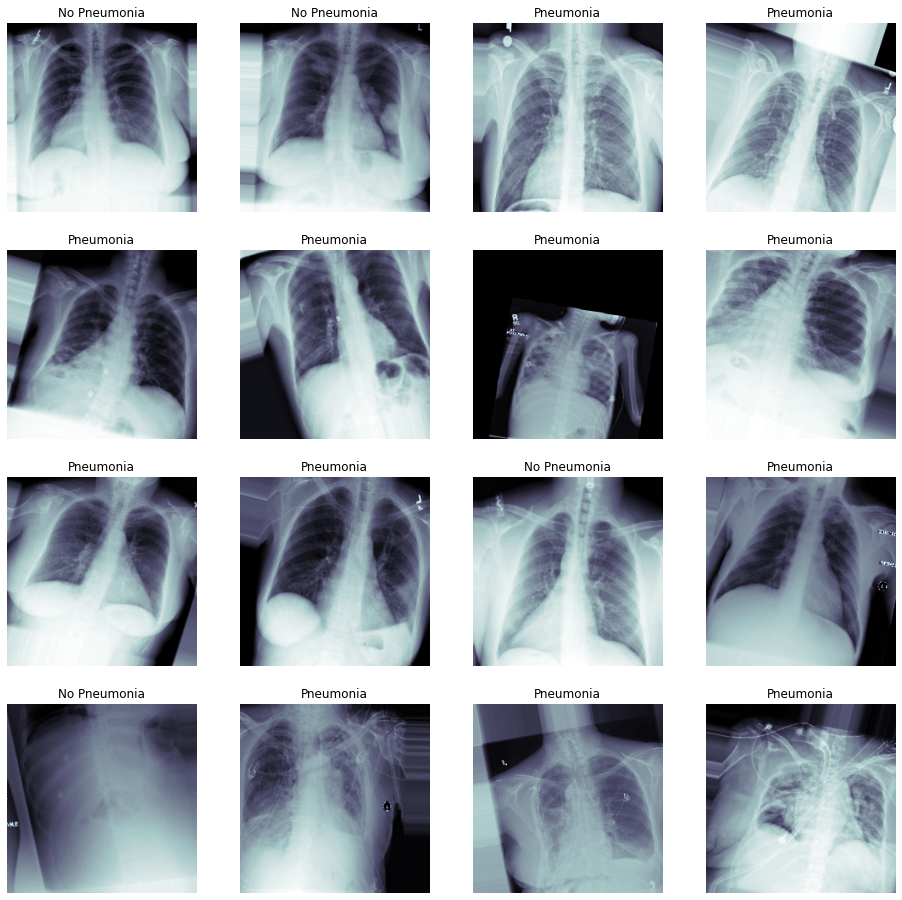

In [52]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

# Data Pre-processing

In [19]:
#Training mean calculation for Mean Centering for future
train_gen_all = train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col ='path' ,
                                          y_col ='class' ,
                                          class_mode = 'binary',
                                          target_size = (224,224) , 
                                          batch_size = len(train_df) )

Found 2289 validated image filenames belonging to 2 classes.


In [20]:
t_x_all, t_y_all = next(train_gen_all)

In [24]:
Mean_image_array=t_x_all.mean(axis=0)
Std_image_array=t_x_all.std(axis=0)

In [27]:
#saving mean and std deviation for future use
np.save('Mean_training_image.npy',Mean_image_array)
np.save('Std_training_image.npy',Std_image_array)

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [53]:
model = VGG16(include_top=True, weights='imagenet')
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [54]:
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dropout(0.5))
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [55]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

In [56]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [57]:
weight_path="{}_my_model.best_epoch100_patience10.hdf5".format('Pneumonia')
checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=20)

callbacks_list = [checkpoint, early]

### Start training! 

In [58]:
## train your model

# Todo

history = new_model.fit_generator(train_gen,validation_data = (valX, valY),epochs =100,callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 60s 833ms/step - loss: 0.7667 - binary_accuracy: 0.5356 - val_loss: 0.6571 - val_binary_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 0.65712, saving model to Pneumonia_my_model.best_epoch100_patience10.hdf5
Epoch 2/100
72/72 [==============================] - 56s 780ms/step - loss: 0.7031 - binary_accuracy: 0.5710 - val_loss: 0.6063 - val_binary_accuracy: 0.7188

Epoch 00002: val_loss improved from 0.65712 to 0.60634, saving model to Pneumonia_my_model.best_epoch100_patience10.hdf5
Epoch 3/100
72/72 [==============================] - 56s 774ms/step - loss: 0.6648 - binary_accuracy: 0.6077 - val_loss: 0.6367 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.60634
Epoch 4/100
72/72 [==============================] - 56s 784ms/step - loss: 0.6490 - binary_accuracy: 0.6291 - val_loss: 0.5938 - val_binary_accuracy: 0.5938

Epoch 00004: val_loss improved from 0.60634 to 0.59377, saving model to Pne

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [59]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


In [60]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
# Todo
    fpr, tpr, thresholds =roc_curve(t_y, p_y)
    
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    return fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 


def precision_recall(t_y, p_y):
    fpr, tpr, thresholds=roc_curve(t_y, p_y)
    
    Total_P=sum(t_y)
    Total_N=len(t_y)-Total_P
    tp=tpr*Total_P # tp: true positive
    fp=fpr*Total_N # fp: false positive
    
    recall=tpr
    precision=tp/(tp+fp)
    
    return precision,recall
# Todo

#Also consider plotting the history of your model training:

def plot_history(history):
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    # Todo

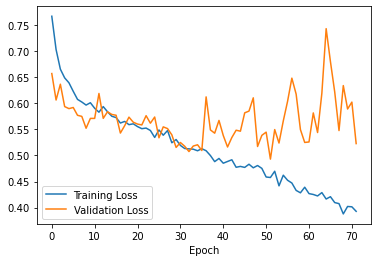

In [61]:
## Plotting Model history
plot_history(history)

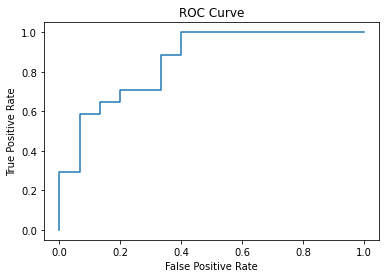

In [62]:
# Printing ROC Curve
tpr,fpr,threshold=plot_auc(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Threshold for Max F1score=[0.39418465]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


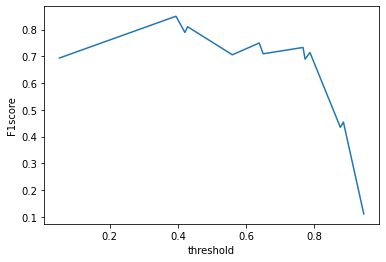

In [63]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
# Optimized model for best F1 score

mdl_precision, mdl_recall=precision_recall(valY, pred_Y)
F1score=2*mdl_precision*mdl_recall/(mdl_precision+mdl_recall)
plt.plot(threshold,F1score)
plt.xlabel('threshold')
plt.ylabel('F1score')
opt_threshold=threshold[F1score==np.nanmax(F1score)]
print ('Threshold for Max F1score={}'.format(opt_threshold))
# Todo

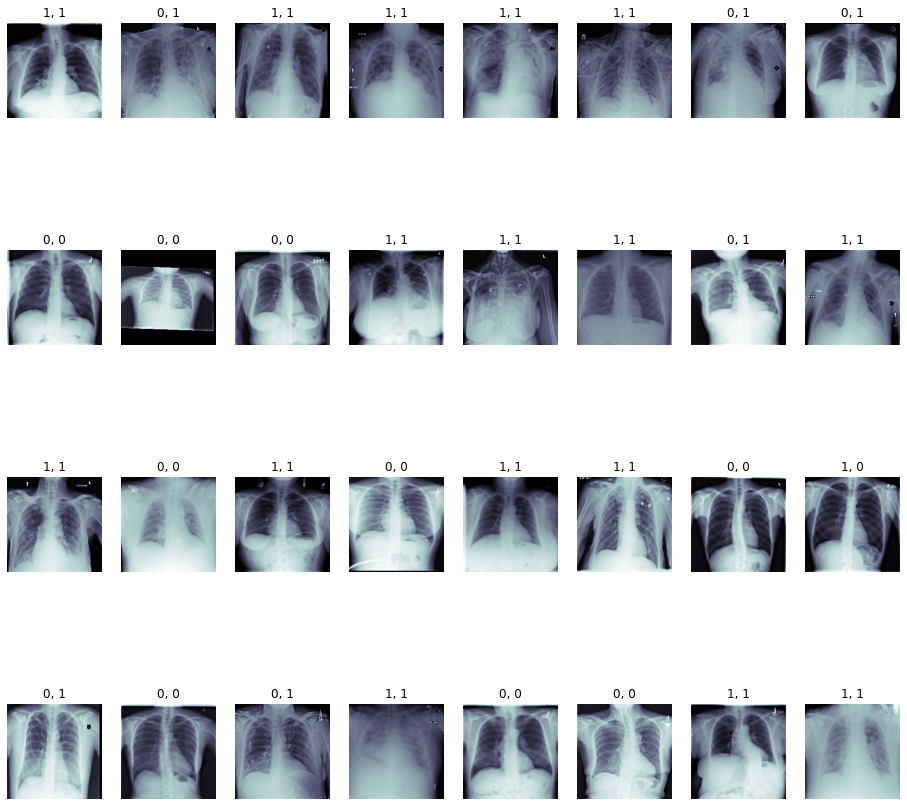

In [64]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
fig, m_axs = plt.subplots(4, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > opt_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > opt_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [65]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model_epoch100_patience20.json", "w") as json_file:
    json_file.write(model_json)